In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Verify GPU is detected

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Training parameters

In [3]:
BATCH_SIZE = 32
EPOCHS = 64

# Image size in pixels.
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Number of images in the training set.
N_TRAIN = 481

# Number of image classes / categories.
CLASS_COUNT = 9

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Load Data

In [4]:
# Directories of data, each catergory / class of data is in a seperate folder.
# TRAINING_DIR = "training_data/training"
# VALIDATION_DIR = "training_data/validation"
TRAINING_DIR = "reduced_training_data/training"
VALIDATION_DIR = "reduced_training_data/validation"

In [5]:
# Rescale here refers to scaling the pixel values from a range of [0, 255] to a range of [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen_batches = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAINING_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="grayscale",
                                                           class_mode='categorical',
                                                           )

Found 481 images belonging to 9 classes.


In [7]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=VALIDATION_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="grayscale",
                                                              class_mode='categorical')

Found 117 images belonging to 9 classes.


# Model Layers

In [8]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(CLASS_COUNT, activation='softmax')
])



# Optimizer

In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# Compile Model

In [10]:
model.compile(optimizer=get_optimizer(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Tensorboard Logging + Model Summary 

In [11]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31490176  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

# Setup Checkpointing the Model

In [13]:
def get_details():
    DETAILS = "batch_size={}_epochs={}_img=({},{})".format(BATCH_SIZE, EPOCHS, IMG_HEIGHT, IMG_WIDTH)
    return DETAILS

In [14]:
TIMESTAMP = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

BASE_CHECKPOINT_PATH = "checkpoints"

CHECKPOINT_FILE_NAME = "cp-{epoch:04d}.ckpt"
CHECKPOINT_PATH = os.path.join(BASE_CHECKPOINT_PATH, TIMESTAMP, CHECKPOINT_FILE_NAME)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

os.makedirs(CHECKPOINT_DIR)

DETAIL_FILE_NAME = "details.txt"

details_file = open(os.path.join(CHECKPOINT_DIR, DETAIL_FILE_NAME), "w")
details_file.write(TIMESTAMP + "\n")
details_file.write(get_details())
details_file.close()

In [15]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
#                                                  save_weights_only=True,
                                                 verbose=1,
                                                 period=8
                                                )

In [16]:
model.save_weights(CHECKPOINT_PATH.format(epoch=0))

# Train the model

In [17]:
history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1, callbacks=[cp_callback, tensorboard_callback])


Epoch 1/64
16/16 [==============================] - 10s 643ms/step - loss: 0.7415 - accuracy: 0.1206 - val_loss: 0.7383 - val_accuracy: 0.1111
Epoch 2/64
16/16 [==============================] - 9s 540ms/step - loss: 0.7380 - accuracy: 0.0998 - val_loss: 0.7379 - val_accuracy: 0.1111
Epoch 3/64
16/16 [==============================] - 9s 547ms/step - loss: 0.7379 - accuracy: 0.1351 - val_loss: 0.7379 - val_accuracy: 0.1624
Epoch 4/64
16/16 [==============================] - 9s 536ms/step - loss: 0.7374 - accuracy: 0.1518 - val_loss: 0.7375 - val_accuracy: 0.1368
Epoch 5/64
16/16 [==============================] - 9s 569ms/step - loss: 0.7374 - accuracy: 0.1372 - val_loss: 0.7373 - val_accuracy: 0.1880
Epoch 6/64
16/16 [==============================] - 10s 631ms/step - loss: 0.7369 - accuracy: 0.1185 - val_loss: 0.7375 - val_accuracy: 0.1368
Epoch 7/64
16/16 [==============================] - 9s 535ms/step - loss: 0.7384 - accuracy: 0.1227 - val_loss: 0.7371 - val_accuracy: 0.1624
Epoc

16/16 [==============================] - 9s 567ms/step - loss: 0.6951 - accuracy: 0.6029 - val_loss: 0.7148 - val_accuracy: 0.4274
Epoch 48/64
16/16 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.6216
Epoch 00048: saving model to checkpoints\19-06-2020-18-30-04\cp-0048.ckpt
INFO:tensorflow:Assets written to: checkpoints\19-06-2020-18-30-04\cp-0048.ckpt\assets
16/16 [==============================] - 10s 653ms/step - loss: 0.6926 - accuracy: 0.6216 - val_loss: 0.7142 - val_accuracy: 0.4188
Epoch 49/64
16/16 [==============================] - 9s 544ms/step - loss: 0.6919 - accuracy: 0.6424 - val_loss: 0.7137 - val_accuracy: 0.4444
Epoch 50/64
16/16 [==============================] - 9s 535ms/step - loss: 0.6929 - accuracy: 0.6112 - val_loss: 0.7141 - val_accuracy: 0.4188
Epoch 51/64
16/16 [==============================] - 9s 540ms/step - loss: 0.6906 - accuracy: 0.6466 - val_loss: 0.7150 - val_accuracy: 0.4359
Epoch 52/64
16/16 [==============================] -

# Display Results

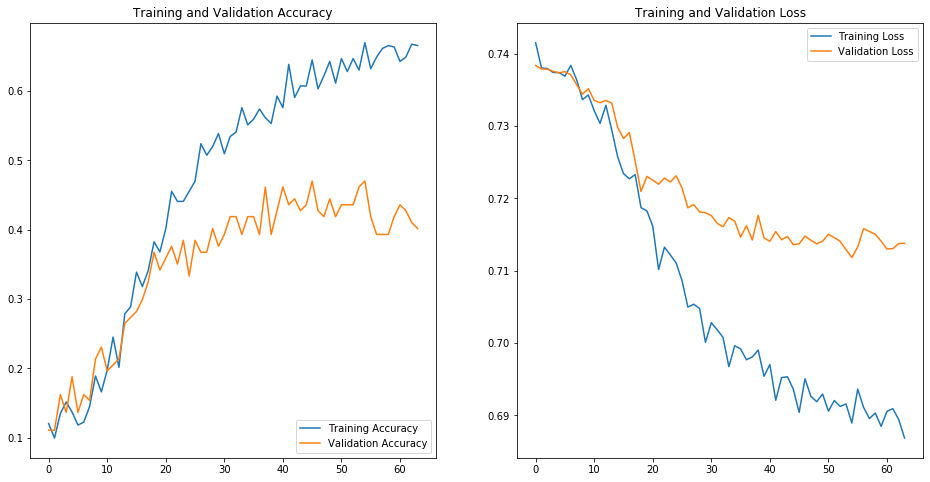

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

file_name = "graph.png"

plt.savefig(os.path.join(CHECKPOINT_DIR, file_name))

plt.show()